In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy
from pyDOE2 import lhs

T_START = 0
T_S = 0.5
T_END = 20

NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_POINTS = 100
NUM_COLLOCATION = 1000
PATIENCE = 100
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


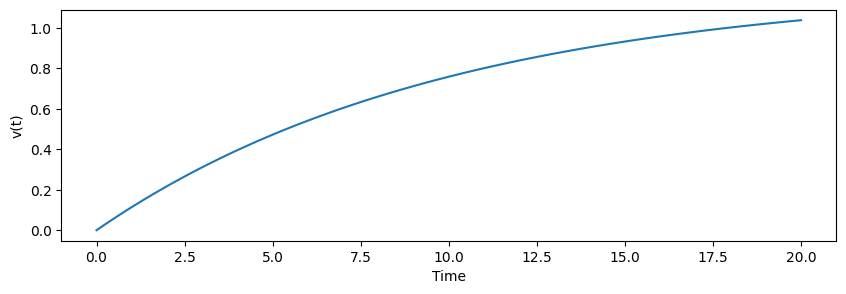

In [3]:
def p(t):
    return 100

def ode_model(v, t):
    mass = 500
    b = 50
    K = .8
    return 1/mass * (-v * b - K * b + p(t))

# Set the initial conditions
v0 = 0
t = np.linspace(T_START, T_END, 100)

# Solve the ODEs
sol = odeint(ode_model, v0, t)

# Plot the solution
plt.figure(figsize=(10,3))
plt.plot(t, sol)
plt.xlabel('Time')
plt.ylabel('v(t)')
plt.show()


In [4]:
# Generate a dataset
def generate_uniform(num_points: int) -> pd.DataFrame:
    df = pd.DataFrame(columns=["t", "v", "p"])
    df["v"] = np.random.uniform(0.0, 40, num_points)
    df["p"] = np.random.uniform(1.0, 100, num_points)
    df["t"] = 0.0
    return df

def generate_lhs(v_range: list, p_range: list, t_range: list, num_points: int) -> pd.DataFrame:
    # Use LHS to generate samples in the unit interval [0, 1]
    lhs_samples = lhs(3, samples=num_points)  # 3 dimensions: x1, x2, u
    # Scale the samples to the desired ranges
    v_samples = v_range[0] + (v_range[1] - v_range[0]) * lhs_samples[:, 0]
    p_samples = p_range[0] + (p_range[1] - p_range[0]) * lhs_samples[:, 1]
    t_samples = t_range[0] + (t_range[1] - t_range[0]) * lhs_samples[:, 2]
    # Combine the results
    df = pd.DataFrame({"t": t_samples, "v": v_samples, "p": p_samples})  
    return df

# df = generate_uniform(NUM_POINTS)
df = generate_lhs(v_range=[0.0, 40.0], p_range=[1.0, 100], t_range=[0, 0], num_points=NUM_POINTS)
print(f"Dataset shape: {df.shape}")

Dataset shape: (100, 3)


In [5]:
def np_to_ts(x):
    return (
        torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1).to(DEVICE)
    )

def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x


def loss_fn(net: PINN, X_train: torch.Tensor):
    df_col = generate_lhs(v_range=[0.0, 40.0], p_range=[1.0, 100], t_range=[0, T_S], num_points=NUM_COLLOCATION)
    t_col = np_to_ts(df_col["t"].values).to(DEVICE)
    v_col = np_to_ts(df_col["v"].values).to(DEVICE)
    p_col = np_to_ts(df_col["p"].values).to(DEVICE)
    
    X_col = torch.cat((t_col, v_col, p_col), 1).to(DEVICE)

    preds = net.forward(X_col)

    v_pred = preds[:, 0]

    dvdt = grad(v_pred, t_col)[0]
    
    error_ode = nn.MSELoss()(dvdt, 1/500 * (-v_pred * 50 - 0.8 * 50 + p_col))
    
    return error_ode

In [6]:
t_train = np_to_ts(df["t"].values)
v_train = np_to_ts(df["v"].values)
p_train = np_to_ts(df["p"].values)

X_train = torch.cat([t_train, v_train, p_train], dim=1)
y_train = v_train

In [7]:
net = PINN(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Loss weights
w_data, w_ode, w_ic = 1, 1, 1

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    preds = net.forward(X_train)

    loss_data = nn.MSELoss()(preds, y_train)

    loss_ode = loss_fn(net, X_train)

    loss = w_data * loss_data + w_ode * loss_ode
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}"
        )

    if epoch >= EARLY_STOPPING_EPOCH:
        if loss < best_loss - threshold:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 1000
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")
                net.load_state_dict(best_model_weights)
                break

c:\Users\mexis\anaconda3\envs\main\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1000, 1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss_data: 520.8795, Loss_ode: 0.0041


### Autoregression

In [9]:
# Create validation set
t_val = t.copy()
v_val = sol[:, 0].copy()
p_val = [p(t) for _ in range(len(t_val))]
X_val = torch.tensor(
    np.array([t_val, p_val, p_val]).T, dtype=torch.float32
).to(DEVICE)
y_val = torch.tensor(v_val, dtype=torch.float32).to(DEVICE)

In [14]:
v_0 = v_val[0]
p_0 = p_val[0]

v_preds = []
for i in range(1, len(t_val)):
    y_k = net.forward(
        torch.tensor([T_S, v_0, 100], dtype=torch.float32).to(DEVICE)
    )
    v_0 = v_val[i]  # Yeah! Control
    v_preds.append(y_k[0].item())

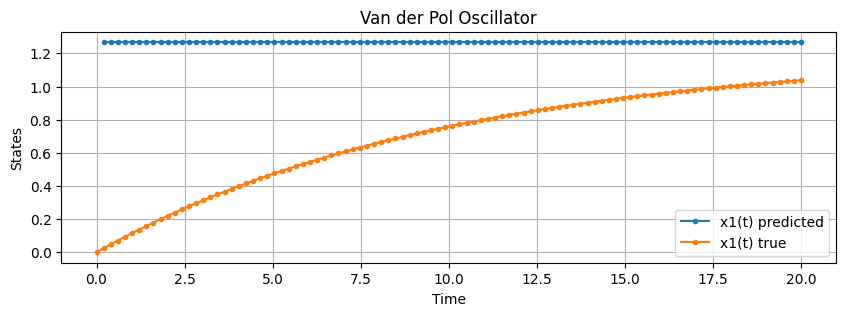

In [15]:
# Plot x1_preds
plt.figure(figsize=(10, 3))
plt.plot(t_val[1:], v_preds, marker="o", markersize=3, label="x1(t) predicted")
plt.plot(t_val, v_val, marker="o", markersize=3, label="x1(t) true")
plt.title("Van der Pol Oscillator")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

# Control

In [178]:
from gekko import GEKKO

m = GEKKO()
m.time = np.linspace(T_START, T_END, 100)

# Parameters
mu = 1
# Manipulated variable
u = m.MV(value=0.45, lb=-1, ub=1)
u.STATUS = 1 # allow optimizer to change
u.DCOST = 0.01 
u.DMAX = 0.8 # How much the control can change

# Controlled variables
x1 = m.CV(value=-2.0)
x2 = m.CV(value=1.0)
x1.STATUS = 1 # add the SP to the objective
x2.STATUS = 1 # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
x1.SP = 0.6 # setpoint
x1.TR_INIT = 1 # setpoint trajectory
x1.TAU = T_s # time constant of setpoint trajectory
x2.TAU = T_s 

def vdp_nn(x1, x2, u):
    x1 = torch.tensor(x1, dtype=torch.float32)
    x2 = torch.tensor(x2, dtype=torch.float32)
    u = torch.tensor(u, dtype=torch.float32)
    
    preds = net.forward(torch.tensor([T_s, x1, x2, u], dtype=torch.float32)).detach().numpy()
    return preds[0], preds[1]       

x1_prev = x1.value.value
x2_prev = x2.value.value

for t in m.time:
    x1_pred, x2_pred = vdp_nn(x1_prev, x2_prev, u.value.value)
    
    m.Equation(x1 == x1_pred)
    m.Equation(x2 == x2_pred)
    
    x1_prev = x1_pred
    x2_prev = x2_pred
    
m.options.IMODE = 6 # control
m.solve(disp=False)

Exception:  @error: Solution Not Found


In [146]:
results_df = pd.read_csv(m.path + '\\results.csv', header=None).T
results_df.columns = results_df.iloc[0]
results_df = results_df[1:]

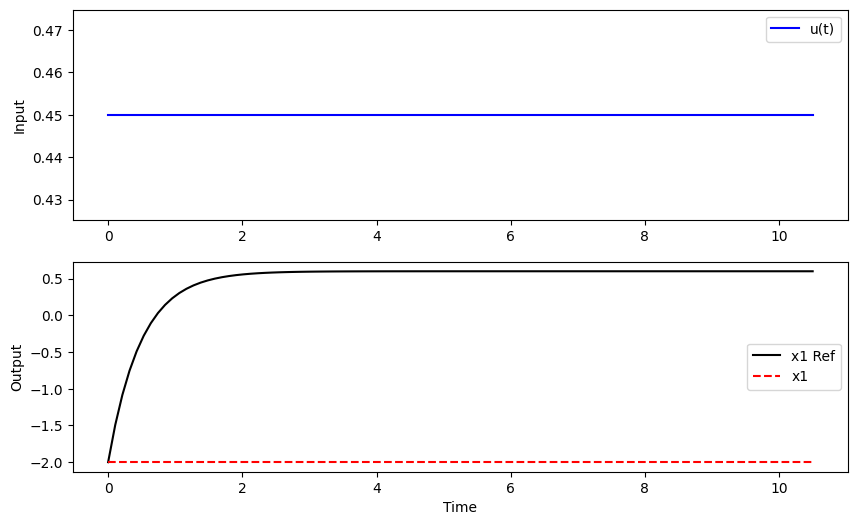

In [179]:
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(m.time, u.value, 'b-', label='u(t)')
plt.legend()
plt.ylabel('Input')
plt.subplot(2,1,2)
plt.plot(m.time, results_df['v1.tr'], 'k-', label='x1 Ref')
plt.plot(m.time, x1.value, 'r--', label='x1')   
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

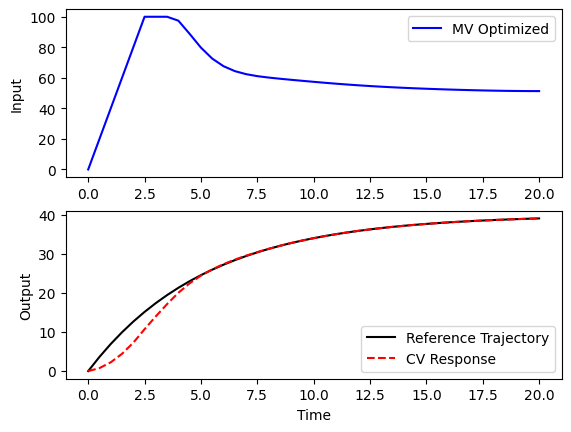

In [184]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

m = GEKKO()
m.time = np.linspace(0,20,41)

# Parameters
mass = 500
b = m.Param(value=50)
K = m.Param(value=0.8)

# Manipulated variable
p = m.MV(value=0, lb=0, ub=100)
p.STATUS = 1  # allow optimizer to change
p.DCOST = 0.1 # smooth out gas pedal movement
p.DMAX = 20   # slow down change of gas pedal

# Controlled Variable
v = m.CV(value=0)
v.STATUS = 1  # add the SP to the objective
m.options.CV_TYPE = 2 # squared error
v.SP = 40     # set point
v.TR_INIT = 1 # set point trajectory
v.TAU = 5     # time constant of trajectory

# Process model
m.Equation(mass*v.dt() == -v*b + K*b*p)

m.options.IMODE = 6 # control
m.solve(disp=False)

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)

plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,p.value,'b-',label='MV Optimized')
plt.legend()
plt.ylabel('Input')
plt.subplot(2,1,2)
plt.plot(m.time,results['v1.tr'],'k-',label='Reference Trajectory')
plt.plot(m.time,v.value,'r--',label='CV Response')
plt.ylabel('Output')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()